# Progetto basato su conoscenza
Progetto basato su conoscenza per l'esame di Ingegneria Della Conoscenza

## 1) Introduzione

Risultati su studi che intercettano fattori di abbandono dei giochi online multigiocatore, mostrano che le motivazioni più rilevanti sono dovute da: https://www.sciencedirect.com/science/article/abs/pii/S1875952117300770

- problemi di attesa, latenza/prestazioni(più rilevanti)
- l'equità del gioco(divario tra giocatori).

### 1.1) Scenario
Si simula lo scenario in cui verrà avviato un nuovo servizio online per il lancio di un nuovo gioco multiplayer. Dato dal picco di giocatori nei primi giorni di uscita del servizio, si prevede si dovrà gestire un carico molto elevato di richieste di partecipazione da parte degli utenti. Si assume che:

- Le risorse server potrebbero risultare limitate rispetto alla popolazione di giocatori 
- Periodicamente viene fornito al sistema un numero limitato di partite istanziabili rispetto alle risorse disponibili
- Ci siano un certa popolazione di giocatori in fase di ricerca di una nuova partita
- In base a dei lavori di ricerca è stato constatato che giocatori tendono ad abbandonare la ricerca di una partita se: i giocatori attendono in coda da troppo tempo, le partite sono composte da giocatori troppo differenti rendendo il gioco squilibrato e frustrante 

### 1.2) Obiettivi
L'obiettivo di questo problema è gestire al meglio il picco di giocatori atteso al lancio del servizio, i criteri per massimizzare e incentivare l'utilizzo del nuovo servizio saranno:

- Ottimizzare al meglio l'utilizzo delle risorse(limitate) massimizzando la popolazione delle partite e penalizzando quei giocatori che tendono ad abbandonare spesso le partite, "sprecando" le risorse disponibili
- Ridurre i rischio di abbandono da parte dei giocatori, legato a lunghe attese(coda) o a partite squilibrate. 
- classificare periodicamente i nuovi giocatori rispetto alle loro statistiche affinchè vengano assegnati ad una certa classe.

#### Strumenti usati per codificare gli obiettivi
**Clustering**: Un algoritmo di *apprendimento non supervisionato* ci permetterà di dividere in cluster(classi naturali) i giocatori rispetto ad una adeguata selezione delle features, permettendo la costruzione di partite equilibrate. L'algoritmo non supervisionato sfrutterà la conoscenza pregressa  sui giocatori iscritti alla piattaforma rispetto ai giochi precedentemente giocati.

**Classificazione**: Algoritmi di *apprendimento supervisionato* ci

**Ricerca di soluzioni vincolate**: Un algoritmo di ricerca costruirà l'assegnazione ottimale(CSP) che codificherà le assegnazioni dei giocatori alle partite, seguendo i criteri e le preferenze definite tra gli obiettivi.

## 2) Dataset
Primo tentativo è stato quello ottenere i dati di statistiche tramite web scraping ma a causa del tempo limitato e del **Rate Limiting** posto dalla piattaforma ho optato per cercare un dataset già costruito(generalemente dataset di questo tipo sono rarissimi).
Il dataset è ottenuto su [https://www.kaggle.com/datasets/fahadalqahtani/cod-vanguard-stats](Kaggle), un campione di circa trecicimila tuple di statistiche su giocatori del gioco Call Of Duty Vanguard. Le features fornite sono:


- **matches**: Numero di partite multigiocatore giocate dal giocatore.
- **play_time**: Tempo totale trascorso dal giocatore giocando a Call of Duty, in ore.
- **kills**: Numero di uccisioni effettuate dal giocatore in tutte le sue partite.
- **deaths**: Numero di volte in cui il giocatore è stato ucciso nel gioco.
- **assists**: Numero di volte in cui il giocatore ha danneggiato un nemico ma un compagno di squadra ha completato l'uccisione. Un valore alto indica che altri giocatori tendono a completare o rubare l'uccisione iniziata dal giocatere.
- **headshots**: Numero di colpi alla testa inflitti ad altri giocatori.
- **suicides**: Numero di volte che il giocatore si è sucidato.
- **wins**: Numero di volte in cui il giocatore ha vinto una partita.
- **losses**: Numero totale di partite perse.
- **score**: Punti Esperienza (XP), una quantità numerica esclusiva per il multigiocatore che determina il livello e il progresso di un giocatore nel gioco.
- **missed_shots**: Numero di volte in cui il giocatore ha mancato il colpo.
- **hits_shots**: Numero di volte in cui il giocatore ha colpito un altro giocatore.


Si assume che i dati utilizzati ottenuti siano parte di conoscenza pregressa appartenente a statistiche del gioco di precedente generazione.

## 3) Pre-processing dataset conoscenza pregressa 
In questa fase si utilizzano librerie ampiamente note, per effettuare pre-processing sui dati grezzi

#### 3.1) Feature Derivation
Vengono costruite features derivate da quelle di partenza. Queste sono utili per i task successivi:
- **game_exits** = gamesPlayed - (wins + losses)
- **kd_ratio**: Rapporto uccisioni/morti, usando le features *deaths* e *kills*. Un giocatore con un valore più alto tenderà ad aver fatto molte più uccisioni che morti, contribuendo alla vittoria della partita.
[//]: #- **mh_ratio**: Rapporto colpi andati a segno/colpi non andati a segno, usando le features *hits_shots* e *missed_shots*. Un giocatore con un valore più alto tenderà a mettere a segno più colpi.

In [29]:
import pandas as pd

# carica dataset nel dataframe
df = pd.read_csv('datasets/cod_vanguard_player_stats_raw.csv')

# feature derivation
df['kd_ratio'] = df['kills'] / df['deaths']
# df['mh_ratio'] = df['hits_shots'] / df['missed_shots']
df['game_exits'] = df['matches'] - (df['wins'] + df['losses'])

#### 3.2) Data cleaning e rimozione duplicati
Questa fase di pre-processing consiste nell'applicare:
- **Data Cleaning**: Pulizia di dati con valori nulli e valori negativi(su 13 tuple ci sono 2 valori negativi probabilmente dovuti ad errori durante la raccolta dei dati). Ci sono circa 13 mila tuple, quelle difettose sono di gran lunga minori. Rimuovere le tuple problematiche non andrà ad inficiare l'informatività del dataset. 
- **Rimozione duplicati**
- **Rimozione di tuple anomale**: Visualizzando i dati in ordine noto che alcune tuple hanno valore *missed_shots* pari a zero nonostante abbiano valori molto alti in altre features, sarà ad anomalie, per cui queste tuble vengono eliminate. Non ho trovato altre anomalie.
- **Rappresentazione feature play_time**: Ricavare solo il dato numerico dei minuti totali partendo dal formato stringa hours minutes

In [30]:
# Data Cleaning - verifica dei valori mancanti
'''
print('-Verifica valori mancanti-')
print(df.isnull().sum())
'''
# rimozione valori negativi per le features
df = df[df['game_exits'] >= 0]


# rimozione duplicati
df.drop_duplicates(inplace=True)

# rimozione tuple anomale
df = df[df['missed_shots'] != 0]

# conversione stringa hours minutes in valore intero rappresentate i minuti
# funzione per convertire il formato in minuti totali
def convert_play_time_to_minutes(play_time_str):
    # split stringa
    parts = play_time_str.split(' ')
    hours = int(parts[0].replace('h', ''))
    minutes = int(parts[1].replace('m', ''))
    
    # tot minuti
    total_minutes = hours * 60 + minutes
    return total_minutes
# applicazione della funzione alla colonna "play_time" per convertire tutto in minuti
df['play_time'] = df['play_time'].apply(convert_play_time_to_minutes)


# salvataggio dataset preprocessed 
import os
file_path = 'datasets/df_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
    
df.to_csv(file_path, index=False)

#### 3.3) Outlier
Tramite boxplot delle singole features degli esempi, questi sono risultati essere coerenti con una distribuzione realistica e informativa, non ci sono valori eccessivamente anomali.

#### 3.4) Normalizzazione delle features
Una vulnerabilità del K-means è quello di essere sensibile a scale di features troppo differenti in termini di dimensioni. Si adopera quindi una tecnica di **scaling** per **standardizzazione** le features, features con scale trooppo grandi tendono a dominare. Per la normalizzazione viene usato **z-score** che trasforma la distribuzione di ogni features in una distribuzione normale standard con media 0 e deviazione standard 1. La standardizzazione(o generalmente normalizzazione) consentirà di rendere le diverse features comparabili tra loro, indipendentemente dalla loro scala originale di partenza.
Viene quindi generato un secondo dataset normalizzato per il task di apprendimento non supervisionato(K-means).

In [31]:
from sklearn.preprocessing import StandardScaler

dfPreStand = pd.read_csv('datasets/df_preprocessed.csv')

# scaling(z-score)
scaler = StandardScaler()
features_to_normalize = ['matches', 'play_time', 'kills', 'deaths', 'assists', 'headshots', 'suicides', 'wins', 'losses', 'score', 'missed_shots', 'hits_shots', 'game_exits']
dfPreStand[features_to_normalize] = scaler.fit_transform(dfPreStand[features_to_normalize])


# salvataggio del dataset per il k-means standardizzato
file_path = 'datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfPreStand.to_csv(file_path, index=False)

## 4) Apprendimento Non Supervisionato
Tramite apprendimento non supervisionato si avvalora una certa features Y non conosciuta. Quello che si vuole fare è costruire una **classificazione naturale dei dati** che non conosciamo. Tramite clustering voglio quindi partizionare l'insieme dei giocatori secondo pattern e somiglianze nei dati. Queste somiglianze devono raggruppare giocatori con comportamenti/pattern di gioco simili. 

#### 4.1)  Utilità del clustering nel problema
Specificamente al nostro problema ci servirà intercettare le *k* classi di giocatori simili, da assegnare all'insieme degli esempi. Dopo aver intercettato le k classi, durante la configurazione delle istanze delle partite di gioco, l'algoritmo di ricerca locale(CSP) utilizzerà l'informazione sulle classi per distribuire nelle partite giocatori della stessa classe, rendendole più equilibrate. L'intento e il funzionamento dell'algoritmo di ricerca viene spiegato più avanti. 

#### 4.2) Scelta approccio e algoritmo
Per rendere più flessibile la scelta dei giocatori rispetto alla classe ho valutato i due approcci Soft e Hard Clustering.

Il Soft Clustering permetterebbe di creare un sistema più flessibile in quanto ogni esempio apparterrebbe ad ogni classe con una certa distribuzione di probabilità. Rispetto agli algoritmi affrontati nel corso, però, l'algoritmo affrontato per il Soft Clustering(Expectation e Maximization) fa un'assunzione di indipendenza condizionata sulle variabili(Naive Bayes), assunzione che nel mio caso non potrei assicurare come realistica. Ho quindi optato per l'approccio'Hard Clustering utilizzando **K-means**, anche per semplificare la soluzione del problema.

#### 4.3) Scelta delle features per l'addestramento
La scelta delle features per l'addestramento non supervisionato è stata fatta in modo empirico rispetto ad assunzioni personali. L'obiettivo è stato quello di isolare le features che probabilmente riflettono lo stile di gioco dei giocatori. Le **features scelte** sono: *matches*, *play_time*, *kills*, *deaths*, *assists*, *headshots*, *score*, *missed_shots*, *hits_shots*
Il resto delle features sono state scartate per il clustering per i seguenti motivi:
- *wins* e *losses*: Sono features che dicono poco sul giocatore, in quanto le squadre sono composte da più giocatori e rifletterebbero più il risultato di una squadra

#### 4.4) Scelta del valore naturale di *K*
Un altro dettaglio da curare nel K-means è la scelta dell'iperparametro *k*, ovvero la quantità di classi con cui far lavorare l'algoritmo. Un modo per trovare il suo **valore naturale** è utilizzare la **regola del gomito**, che consiste nel partire da un certo *k* basso e incrementarlo via via, cercando il numero ottimale di cluster *k* fino a un masso di iterazioni. La regola consiste nel calcolare la **somma delle distanze quadratiche(inertia)** tra ogni esempio(punto nello spazio) e i centroidi assegnati(classe), selezionando il valore di k per il quale questa somma inizia a ridursi lentamente.

L'algoritmo verrà quindi eseguito su *k* che varierà da 1 a 11. Al metodo KMeans vengono passati i seguenti parametri:
- ***init='k-means++'***: È una tecnica di inizializzazione nella scelta i centroidi iniziali in modo più intelligente e non in modo casuale(ad esempio scegliendo centroidi distanti tra loro), questo aiuta ad innescare l'algoritmo, migliorandone la convergenza. 
- ***max_iter=300***: Rappresenta il numero massimo di iterazioni che K-means effettua durante la ricerca dei centroidi per i cluster
- ***n_init=10***: Rappresenta quanti **random restart effettuare** sulla singola scelta di k in modo da partire da diverse configurazioni di centroidi e scegliendo il miglior risultato che useremo per il calcolo dell'inertia

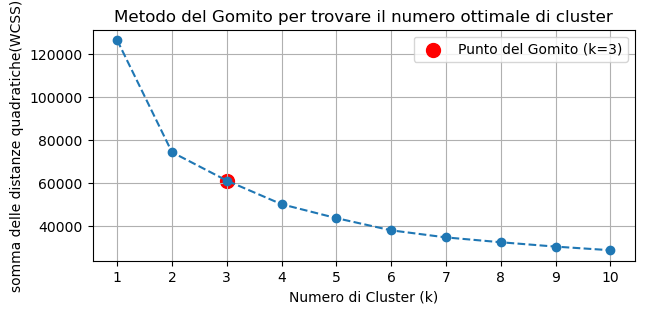

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# caricamento del dataset per il k-means standardizzato
dfPreStand = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')

# features usate per il clustering
featuresTocluster = ['matches', 'play_time', 'assists', 'kd_ratio', 'assists', 'headshots',
                        'score', 'missed_shots', 'hits_shots', 'suicides']
X = dfPreStand[featuresTocluster]

# vettore delle somme delle distanze quadratiche(inertia) per k che varierà nel range
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia è il valore del WCSS per k
    
    
# Traccia il grafico della regola del gomito
plt.figure(figsize=(7, 3))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('somma delle distanze quadratiche(WCSS)')
plt.title('Metodo del Gomito per trovare il numero ottimale di cluster')
plt.xticks(k_range)  # Visualizza ogni valore di k sull'asse x
plt.grid(True)

# punto del gomito su k=3
plt.scatter(3, wcss[2], s=100, c='red', label='Punto del Gomito (k=3)')
plt.legend()
plt.show()

Come si può notare dopo *k=3* l'inertia diminuisce in modo meno significativo, per cui il *valore naturale*, ovvero il miglior valore è *k=4*.

#### 4.5) Assegnazione degli esempi alle classi
A questo punto trovato k, si proce con l'esecuzione del k-means con *k=4*(cluster) e si assegnano le classi agli esempi del dataset.

In [33]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)


# aggiunta delle label risultanti(classi) ai dataset preprocessati
dfStandClustered = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')
dfClustered = pd.read_csv('datasets/df_preprocessed.csv')


# aggiunta label classe giocatore ai due dataset
dfStandClustered['cluster_label'] = kmeans.labels_
dfClustered['cluster_label'] = kmeans.labels_


# salvataggio del dataset con label sulla classe(clustering) del giocatore
file_path = 'datasets/player_class_datasets/df_stand_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfStandClustered.to_csv(file_path, index=False)

file_path = 'datasets/player_class_datasets/df_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfClustered.to_csv(file_path, index=False)

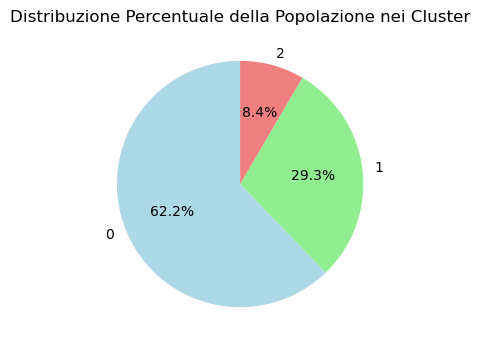

In [34]:

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
plt.figure(figsize=(4, 4))

# Conta il numero di punti in ciascun cluster
cluster_counts = dfClustered['cluster_label'].value_counts()

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('')
plt.title('Distribuzione Percentuale della Popolazione nei Cluster')
plt.show()

## .1) Constrained Optimization Problem

L'idea è quella di rappresentare il problema dell'assegnazione delle risorse limitate tramite uno spazio di ricerca in cui un algoritmo ricerca le soluzioni(assegnazioni di variabili) rispettando hard constraint e preferendo soft constraint. 

La scelta dell'algoritmo con cui risolvere il problema è stata guidata da due considerazioni principali: 

- Ci sono alcuni vincoli che devono essere inviolabili tramite **Hard Constraints**, come la capacità massima di giocatori in una partita
- L'algoritmo deve gestire uno scenario in cui le risorse sono limitate(partite istanziabili), consentendo il fatto che alcuni giocatori potrebbero non riuscire ad essere assegnati ad alcuna partita ovvero che i vincoli vengano soddisfati solo parzialmente. Questo potremmo codificarlo tramite **Soft Constraints**.
- L'algoritmo deve quindi cercare la soluzione ottimale soddisfando quanti più soft constraints(di cui ognuno avrà una certa importanza), consentendo la violazione di alcuni ma massimizzando l'ottimalità della soluzione

Queste considerazioni non descrivono altro che un **Problema Di Ottimizzazione Vincolato**. In cui il problema viene codificato tramite **Hard Constraints**, **Funzione Obiettivo** o **Soft Constraints**, questi ultimi due guideranno la ricerca verso una soluzione ottimale. Una soluzione ottimale sarà la migliore soluzione che soddisfa tutti i criteri definiti(soft constraints - funzione obiettivo). Nel nostro caso non vogliamo una semplice soluzione, ovvero giocatori assegnati per partite che non superino la capacità massima, ma vogliamo la migliore soluzione rispetto a criteri che verranno definiti successivamente in questo documento.

### .2)  Google OR-Tools 
Per il tipo di problema *Problema di Ottimizzazione Vincolato* ho utilizzatog la libreria [Google OR-Tools](https://developers.google.com/optimization?hl=it). Una libreria molte efficiente che consente di risolvere questo tipo di problemi in modo efficiente e permette di gestire aspetti riguardanti:

**Supporto per CSP**: OR-Tools è pensata per risolvere Constraint Satisfaction Problems
**Gestione di Constraint**: consentendo sia vincoli hard(vincoli hard saranno usati per gestire la capacità massima delle partite)
**Funzione Obiettivo**: La funzione obiettivo ci permette di definire cosa rende una soluzione migliore delle altre. I soft constraint saranno codificati in termine di sommatorie di penalità da minimizzate all'interno della funzione obiettivo. Queste penalità vengono costruite in termini delle variabili del CSP. La definizione della *Funzione Obiettivo* da minizzare che muova il problema nella direzione desiderata è un aspetto molto comune in questo tipo di problemi. La progettazione della funzione obiettivo è anche l'aspetto che richiede più sforzi nella sua definizione, ovvero di comprendere come ottenere le soluzioni ottimali desiderate, in termini di penalità che compongono la funzione obiettivo(da minimizzare o massimizzare).


La libreria non implementa tecniche di ricerca locale, ma riconduce un problema ad un sat problem, risolvendolo sistematicamente e applicando pruning o tecniche di branch and bound.

In [35]:
#Installazione Google OR-Tools
!pip install ortools;

In [51]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import numpy as np
import time

# modello
model = cp_model.CpModel()

### .3) Scenario simulato
Per simulare lo scenario è stata selezionata solo una porzione di giocatori dal dataset. Si simuleranno due tipi di scenari, le risorse  messe a disposizione(match istanziabili) saranno: 
- Insufficienti rispetto alle richieste di partecipazione dei giocatori. Si valuterà quanto il sistema è in grado di comporre partite che massimizzi l'efficienza del sistema, e scelga i partecipanti secondo i criteri ottimali più avanti descritti tramite soft constraints e minimizzazione della funzione obiettivo.
- Sufficienti rispetto alle richieste di partecipazione dei giocatori. Si valuterà quanto il solver sfrutta al meglio le partite istanziabili, senza disperdere la popolazione di giocatori, istanziando quindi risorse non necessarie, che sarebbero di vitale importanza nelle iterazioni successive.

In [52]:
# simulazione scenario 1
'''
AVAILABLE_PLAYERS = 203  # giocatori disponibili
INSTANCES_AVAILABLE_MATCHES = 40  # istanze partite disponibili ad essere avviate
PLAYER_CAPACITY_MATCHES = 8  # capacità partite
PLAYERS_CLASS_COUNT = 3  # numero di cluster/classi giocatori
'''
# configurazione di prova
AVAILABLE_PLAYERS = 68  # giocatori disponibili
INSTANCES_AVAILABLE_MATCHES = 13  # istanze partite disponibili ad essere avviate
PLAYER_CAPACITY_MATCHES = 8  # capacità partite
PLAYERS_CLASS_COUNT = 3  # numero di cluster/classi giocatori

### .3.1) Campione giocatori per lo scenario
Per lo scenario simulato vengono selezionati dei campioni casuali di giocatori dal dataset

In [53]:
# Selezione campione casuale di 30 giocatori(seed fisso) dal dataset dfClustered
dfSampleOfPlayers = dfClustered.sample(n=AVAILABLE_PLAYERS, random_state=42)

### .3.2) Codifica Variabili


#### Variabili giocatori
Rispetto alle considerazioni precedenti, codifico la variabile che rappresentava l'appartenenza del giocatore come un vettore di variabili binarie il cui numero di variabili è pari al dominio della variabile codificata di partenza. La variabile che assumerà il valore 1 indicherà l'indice del server di appartenenza per il giocatore. Quindi definisco i giocatori come vettori di variabili indicatrici:

In [54]:
# definizione dei player in termini di un vettore di variabile booleane
playersVars = []
# per ogni giocatore
for p in range(AVAILABLE_PLAYERS):
    # la variabile all'interno del vettore match con valore 1 indicherà il match di appartenenza del giocatore
    belongingToMatch = []
    # creazione di varibile booleane tanti quanti sono i match 
    for m in range(INSTANCES_AVAILABLE_MATCHES):
        belongingToMatch.append(
            model.NewBoolVar(f'player_{p}_in_match_{m}')
        )
    playersVars.append(belongingToMatch)

#### Variabili match
La variabile corrispondente a ogni partita rappresenta quale classe di giocatori assegnati ad essa deve ospitare. Anche questa variabile sarà definita in termini di variabili binarie, per consentire sommatorie condizionali nella fase di definizione dei vincoli.

In [55]:
# definizione dei match in termini di un vettore di variabili booleane, l'assegnazione sul match indica la classe di appartenenza
matchesVars = []

for m in range(INSTANCES_AVAILABLE_MATCHES):
    # la variabile all'interno del vettore match con valore 1 indicherà la classe di giocatori ammessi
    playerClass = []
    # creazione di varibile booleane tante quante sono le classi 
    for c in range(PLAYERS_CLASS_COUNT):
        playerClass.append(
            model.NewBoolVar(f'match_{m}_class_{c}')
        )
    matchesVars.append(playerClass)

### 3.3) Codifica costanti
Vengono definite nel csp costanti che contribuiscono al calcolo dei soft constraint

#### Costanti classi(cluster) di appartenenza dei giocatori
Le classi dei giocatori vengono utilizzate affinchè la funzione obiettivo componga le soluzioni in base alla loro classe, in particolare vogliamo creare partite la cui classe dovrà essere quanto più possibile la medesima per ogni partita.

In [56]:
playerClassesConsts = [] #ogni posizione indica la classe d'appartenenza del giocatore i-esimo
for p in range(AVAILABLE_PLAYERS):
    player_class = dfSampleOfPlayers.iloc[p]['cluster_label']
    # Inserisci ogni classe come costante nel modello
    playerClassesConsts.append(player_class)
    

### .5) Hard constraint


### .5.1) Problema della sommatoria di variabili con dominio non binario nella definizione di un vincolo rigido(#Sommatoria Condizionale#)


Nell'utilizzo di Google OR-Tools ho riscontrato un limite (giustificato). Nel primo tentativo, mentre progettavo le variabili e gli hard constraints da inserire, avevo deciso come scelta progettuale che ogni variabile del giocatere $P_i$(giocatore i-esimo) avrebbe rappresentato la parita a lui assegnata. Il cui dominio:

$$
P_i \quad \text{con} \quad \text{dom}(P_i) = \{ \text{numero di server istanziati} \}
$$

Una volta definite le variabili, per evitare che alle partite fossero assegnati più giocatori della loro capacità massima, ho creato un hard constraint per ogni match $M_j$ che avrebbe controllato che la somma dei giocatori assegnati a un match non superasse la capacità massima, ovvero:

$$
\left( \sum_{\substack{P_i \in \text{players} \\ \land \\ P_i = j}} 1 \right) \leq \text{playerCapacityMatches}
$$

dove `players` è il vettore dei giocatori, `j` è l'indice del match(tra i match istanziati), e `playerCapacityMatches` è la capacità massima delle partite.

### .5.1.1) Sommatoria condizionale
Questa operazione è chiamata **sommatoria condizionale** e con Google OR-Tools non è possibile costruire vincoli di sommatorie che coinvolgono variabili con domini di numeri interi (finiti). Teoricamente, per verificare un vincolo con una sommatoria condizionale, il solver dovrebbe cercare tutte le possibili assegnazioni delle variabili coinvolte nella sommatoria condizionale affinché la condizione sia soddisfatta. In teoria, si potrebbe provare tutte le possibili assegnazioni di tutte le variabili affinchè che la sommatoria condizionale sia rispettata, ma la numerosità dei domini delle variabili renderebbe la complessità del problema estremamente elevata. Anche se dal punto di vista teorico sarebbe possibile trovare un'assegnazione che soddisfi una sommatoria condizionale, la complessità in presenza di variabili con domini ampi renderebbe questa ricerca molto più difficile. Per questo motivo, l'algoritmo della libreria Google OR-Tools non consente di costruire vincoli con sommatorie condizionali in presenza di variabili con domini su più valori.

<img src="doc_images/NonBooleanVariableError.png" alt="Testo Alternativo" style="width: 100%; height: auto;">

### .5.1.2) Soluzione
Consultando la documentazione e vari esempi, ho scoperto che è possibile utilizzare sommatorie condizionali nei vincoli solo se le variabili coinvolte sono **binarie**. In questo caso, la ricerca di un'assegnazione per variabili binarie non ancora assegnate che rispettino la sommatoria condizionale risulta più semplice rispetto alle variabili con domini interi. Il dominio più piccolo delle variabili binarie rende più fattibile la ricerca dell'assegnzione. Ovviamente, se il numero di variabili binarie diventa troppo elevato, il problema persisterà, ma di base la libreria utilizzata disincentiva l'utilizzo diretto delle sommatorie condizionali.


### .5.1.3) Strategia Soluzione
La strategia iniziale che stavo adottando per costruire il CSP era quella di creare una variabile $P_i$ per ogni giocatore, il cui valore avrebbe rappresentato l'indice della partita a cui appartiene.

Questa problematica mi ha portato a riprogettare la struttura delle variabili nel CSP, in cui ogni variabile viene rappresentata tramite **variabili indicatrici** rispetto al dominio della variabile di partenza. Ad esempio:
Se una variabile $Y$ ha un dominio composto da 4 elementi, allora creo 4 variabili indicatrici $(Y_1, Y_2, Y_3, Y_4)$, l'assegnazione di una di queste variabili rappresenterà l'assegnazione su $Y$. Altro dettaglio è che con l'introduzione delle variabili binarie bisogna costruire un vincolo per ogni giocatore che codifica che "solo una di queste variabili può assumere valore 1". Questo può essere rappresentato con una sommatoria condizionale sulle variabili binarie:

$$
\sum_{Y_i \in Y} Y_i \leq 1
$$

A questo punto posso costruire un vincolo di sommatoria condizionale sulle variabili binarie, più complesso ma che mi permette di codificare il vincolo che in precedenza non era possibile esprimere, risolvendo il problema di partenza.

**Nota**: Bisogna ancora codificare un vincolo aggiuntivo che garantisca che solo una variabile possa essere avvalorata(un giocatore può appartenere ad una sola istanza di partita alla volta).

### .5.3) Codifica Hard constraints
Con gli HC si definiscono dei vincoli che informano il solver su quali sono le assegnazioni sulle variabili da scartare.

#### HC appartenenza partita
Per codificare l'appartenenza di un giocatore ad una partita tramite variabili binarie, bisogna introdurre un vincolo per ogni giocatore che controlla che questo appartenga al massimo ad una partita, ovvero che solo una delle variabili binarie $P_{ij}$, fissato $i$, può assumere valore pari a $1$. Questo constraint controlla che la sommatoria dei valori sulle variabili binarie su una riga siano $< 1$. Viene quindi definito un vincolo per ogni giocatore o riga(le righe rappresentano le variabili binarie di appartenenza alle partite del giocatore)

$$
\sum_{j \in \text{matches}} P_{ij} \leq 1, \quad \forall i \in \text{players}
$$

Se la somma delle variabili binarie sarà zero allora i giocatori non apparterranno ad alcuna partita, questo sarà frequente nella situazione di sovraccarico, giocatori che non trovano spazio in alcuna partita restano inassegnati. 

In [57]:
# si definisce un vincolo per ogni giocatore p
for p in range(AVAILABLE_PLAYERS):
    model.Add( 
        sum(playersVars[p][m] for m in range(INSTANCES_AVAILABLE_MATCHES)) <= 1
    )

#### HC classe partita
Anche qui per codificare la classe scelta per la partita tramite variabili binarie, si introduce un vincolo per ogni partita che garantisce che una partita possa essere in relazione con una sola classe

In [58]:
# si definisce un vincolo per ogni match p
for m in range(INSTANCES_AVAILABLE_MATCHES):
    model.Add(
        sum(matchesVars[m][c] for c in range(PLAYERS_CLASS_COUNT)) <= 1
    )

#### .5.3.2) HC Capacità massima partita
Risolto il problema sulla sommatoria condizionale adesso è possibile codificare il vincolo per cui ogni partita non può ospitare più giocatori della sua capacità massima. Questo viene fatto controllando che sommatoria dei valori delle signole variabili binarie di ogni giocatore appartenenti alla colonna non sia maggiore della capacità massima. Viene quindi definito un vincolo per ogni match o colonna(le colonne rappresentano i giocatori appartenenti alla partita).

$$
\sum_{i \in \text{players}} X_{ij} \leq \text{playerCapacityMatches}, \quad \forall j \in \text{matches}
$$

In [59]:
# vincolo: il numero di giocatori per partita non deve superare la capacità massima
for m in range(INSTANCES_AVAILABLE_MATCHES):
    model.Add(
        sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)) <= PLAYER_CAPACITY_MATCHES
    )

### .5) Funzione Obiettivo - Soft Constraints
Dal punto di vista teorico a differenza degli *hard Constraint*, i *soft Constraints* sono vincoli che possono essere violati, questi sono usati come criteri di preferenza sulle possibili assegnazioni ammissibili. Il **solver** generalmente deve trovare la migliore assegnazione totale seguendo queste preferenze, ovvero deve soddisfare i soft constraint nel miglior modo possibile, cercando la soluzione ottimale. Nei *problemi di ottimizzazione vincolata* i *soft Constraints* vengono spesso integrati all'interno della **funzione obiettivo** come somme di penalità o costi. L'obiettivo del problema diventa quindi trovare assegnazioni che minimizzino la funzione obiettivo(**criterio di ottimalità**). 

**Esempio:** Se si vogliono penalizzare assegnazioni sulle variabili che tendono a non assegnare una partita ad ogni giocatore, si può codificare una penalità rispetto a ogni posto vuoto nelle partite. Questa penalità viene inserita come termine della funzione obiettivo che dovrà essere minimizzata per guidare il solver nello stabilire la soluzione ottimale.

### .5.1) Suddivisione del problema in due istanze
Una problematica che potrebbe affliggere i problemi di ottimizzazione vincolata è quello per cui in presenza di una funzione obiettivo troppo complessa o di numerosi hard constraints il problema potrebbe risultare difficile da gestire, con la possibilità che i constraint possano essere contraddittori a causa della loro numerosità, ottenendo risultati insoddisfacenti. Essendo il problema valutabile in due istanze differenti(fase sotto carico e fase sovraccarico), una strategia che ho intrapreso è stata quella di creare due funzioni obiettivo differenti per gestire due istanze differenti del problema. 

Le due funzioni verranno innescate in modo mutualmente esclusivo su due istanze principali del problema:
#### Istanza di sotto carico
La prima funzione obiettivo dovrà gestire il caso in cui la disponibilità delle risorse(le parite) è sufficiente rispetto ai giocatori disponibili per essere assegnati. L'istanza del problema si riduce nel riempire le partite il più possibile, in modo da rendere aumentare le partite istanziabili per le prossime iterazioni.

**Esempio** Se posso istanziare un certo numero di partite e queste sono sufficienti per ospitare i giocatori in attesa, per garantire massima disponibilità in termini di partite i giocatori dovranno distribuirsi cercando di riempirle quanto più possibile. Questo criterio implicherà la presenza di più istanze di partite disponibili per essere istanziate nelle iterazioni successive. Nelle due immagini sotto, a parità di giocatori e di risorse si possono notare le differenze nel loro sfruttamento:
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; margin-right: 4%; width: 45%;">
        <img src="doc_images/wrong_player_distribution_in_match.png" alt="Immagine 1" style="width: 100%; height: auto;">
        <p>Distribuzione che non sfrutta le risorse in modo ottimale, istanziare più partite limita la possibilità di ospitare le partite future</p>
    </div>
    <div style="text-align: center; width: 52%;">
        <img src="doc_images/correct_player_distribution_in_match.png" alt="Immagine 2" style="width: 100%; height: auto;">
        <p>Questa distribuzione sfrutta le risorse in modo ottimale, rendendo possibile l'avvio di partite future a parità di risorse</p>
    </div>
</div>

Oltre all'ottimizzazione del riempimento delle partite, un secondo criterio sarà quello di cercare di mettere insieme nel miglior modo possibile i giocatori della stessa classe(cluster), rendendo l'esperienza ai giocatori meno frustrante, quindi aumentando la loro possibile permanenza sul servizio.
#### Istanza di sovraccarico
La seconda funzione obiettivo dovrà gestire l'istanza del problema per cui la disponibilità delle risorse(partite) non è sufficiente per ospitare tutti i giocatori per cui molti di loro non saranno assegnati ad una partita. L'istanza del problema riempie banalmente tutte le risorse, quindi il problema si incentrerà sulla selezione dei giocatori assegnabili ad una partita che dovra essere codificata,


### .5.2) Costruzione termini penalità funzione obiettivo_1 - istanza di sotto carico
I termini di penalità(soft constraints) che ho valutato per costruire la funzione obiettivo(soft constraint) in questa istanza del problema sono:


#### Massimizzare la popolazione della partita
Incentivare il riempimento delle partite, evitando di istanziare partite sottoutilizzate e quindi di utilizzare ulteriori risorse(limitate). 

Confrontiamo ora due simulazioni nel caso di sovraccarico e sottocarico,

nel caso di sovraccarico vediamo come semplicemente una porzione dei giocatori resti fuori e non venga assegnata, con i prossimi constraint andremo a definire quali saranno le preferenze per cui alcuni giocatori rispetto ad altri sarebbere preferibili per comporre le partite istanziate già ottimizzate


Dimostrato il comportamento corretto dell'algoritmo nel gestire le assegnazioni(distribuzione di giocatori assegnati), adesso andremo a codificare come guidare il solver su come deve comporre le distribuzioni di giocatori all'interno delle partite

In [60]:
# SOFT CONSTRAINT PENALITÀ PARTITE NON PIENE
# il vincolo si assicura che vengano assegnati alle partite quanti più giocatori 

# variabili ausiliarie per contare il numero di giocatori assegnati a ciascuna partita
playersInMatch = [
    model.NewIntVar(0, AVAILABLE_PLAYERS, f'players_in_match_{m}')
    for m in range(INSTANCES_AVAILABLE_MATCHES)
]

# collegare le variabili booleane alle variabili ausiliarie per il conteggio dei giocatori
for m in range(INSTANCES_AVAILABLE_MATCHES):
    model.Add(playersInMatch[m] == sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)))

# penalità di giocatori non assegnati(posti vuoti nelle partite)
penaltyPlayersNotAssignedToMatch = [
    (PLAYER_CAPACITY_MATCHES - playersInMatch[m])
    for m in range(INSTANCES_AVAILABLE_MATCHES)]

In [61]:
# SOFT CONSTRAINT MINIMIZZARE IL NUMERO DI PARTITE CHE NON SONO PIENE

# Definizione delle variabili ausiliarie per indicare se una partita è piena
fullMatchesVars = [
    model.NewBoolVar(f'full_match_{m}') for m in range(INSTANCES_AVAILABLE_MATCHES)
]

# Vincolo che collega la variabile booleana fullmatch al numero di giocatori nella partita
for m in range(INSTANCES_AVAILABLE_MATCHES):
    # Se il numero di giocatori nella partita `m` è uguale alla capacità massima, allora la partita è piena
    model.Add(playersInMatch[m] == PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchesVars[m])
    # Se il numero di giocatori nella partita `m` è inferiore alla capacità massima, la partita non è piena
    model.Add(playersInMatch[m] < PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchesVars[m].Not())

# Penalità per partite non piene
penalita_not_full_match = [
    fullMatchesVars[m].Not() for m in range(INSTANCES_AVAILABLE_MATCHES)
]

In [62]:
# SOFT CONSTRAINT MINIMIZZARE QUANTITÀ PARTITE ISTANZIATE 
# il vincolo penalizza la soluzione se sono state usate meno partite possibili

matchesInstantiatedVars = [
    model.NewBoolVar(f'instantiated_match_{m}') for m in range(INSTANCES_AVAILABLE_MATCHES)
]

# Vincolo che collega la variabile booleana al numero di giocatori nella partita m
for m in range(INSTANCES_AVAILABLE_MATCHES):
    # se c'è' sono almeno 1 giocatore assegnato alla partita `m`, allora la partita è istanziata
    model.Add(playersInMatch[m] > 0).OnlyEnforceIf(matchesInstantiatedVars[m])
    # Se non ci sono giocatori assegnati, la partita non è istanziata
    model.Add(playersInMatch[m] == 0).OnlyEnforceIf(matchesInstantiatedVars[m].Not())

# Penalità per ogni partita istanziata
penalita_partite_istanziate = [
    matchesInstantiatedVars[m] for m in range(INSTANCES_AVAILABLE_MATCHES)
]

#### Partite con giocatori della stessa classe
I giocatori appartenenti a una certa partita devono essere possibilmente della stessa classe(naturale), riducendo la possibilità che questi giocatori differiscano troppo tra loro.

In [63]:
#playerClassesConsts - vettore giocatori con classe associata


# variabili ausiliarie per match, per ogni match vengono create PLAYERS_CLASS_COUNT variabili ausiliarie in cui ognuna conterà il numero
# di giocatori nel match di una certa classe
playersOfClassInMatch = []
for m in range(INSTANCES_AVAILABLE_MATCHES):

    playersOfClass = []
    for c in range(PLAYERS_CLASS_COUNT):
        playersOfClass.append(
            model.NewIntVar(0, AVAILABLE_PLAYERS, f'players_of_class{c}_in_match_{m}')
        )
    playersOfClassInMatch.append(
        playersOfClass
    )


for m in range(INSTANCES_AVAILABLE_MATCHES):
    for c in range(PLAYERS_CLASS_COUNT):        
           model.Add(playersOfClassInMatch[m][c] == sum(playersVars[p][m] and playerClassesConsts[p] for p in range(AVAILABLE_PLAYERS)))
                   

'''
# Variabili di penalità per il numero di classi presenti in ciascuna partita
penalty_different_classes = []

for m in range(INSTANCES_AVAILABLE_MATCHES):
    # Variabili binarie che indicano se ci sono 1, 2 o 3 classi nella partita `m`
    one_class_present = model.NewBoolVar(f'one_class_present_in_match_{m}')
    two_classes_present = model.NewBoolVar(f'two_classes_present_in_match_{m}')
    three_classes_present = model.NewBoolVar(f'three_classes_present_in_match_{m}')
    
    # Conta il numero di classi presenti
    num_classes_present = model.NewIntVar(1, PLAYERS_CLASS_COUNT, f'num_classes_present_in_match_{m}')
    model.Add(num_classes_present == sum(class_presence_in_match[m][c] for c in range(PLAYERS_CLASS_COUNT)))
    
    # Imposta le variabili binarie in base al numero di classi presenti
    model.Add(num_classes_present == 1).OnlyEnforceIf(one_class_present)
    model.Add(num_classes_present != 1).OnlyEnforceIf(one_class_present.Not())
    
    model.Add(num_classes_present == 2).OnlyEnforceIf(two_classes_present)
    model.Add(num_classes_present != 2).OnlyEnforceIf(two_classes_present.Not())
    
    model.Add(num_classes_present == 3).OnlyEnforceIf(three_classes_present)
    model.Add(num_classes_present != 3).OnlyEnforceIf(three_classes_present.Not())
    
    # Aggiungi le penalità in base al numero di classi presenti
    penalty_different_classes.append(one_class_present * 1)
    penalty_different_classes.append(two_classes_present * 2)
    penalty_different_classes.append(three_classes_present * 3)
''' 

" \n# Variabili di penalità per il numero di classi presenti in ciascuna partita\npenalty_different_classes = []\n\nfor m in range(INSTANCES_AVAILABLE_MATCHES):\n    # Variabili binarie che indicano se ci sono 1, 2 o 3 classi nella partita `m`\n    one_class_present = model.NewBoolVar(f'one_class_present_in_match_{m}')\n    two_classes_present = model.NewBoolVar(f'two_classes_present_in_match_{m}')\n    three_classes_present = model.NewBoolVar(f'three_classes_present_in_match_{m}')\n    \n    # Conta il numero di classi presenti\n    num_classes_present = model.NewIntVar(1, PLAYERS_CLASS_COUNT, f'num_classes_present_in_match_{m}')\n    model.Add(num_classes_present == sum(class_presence_in_match[m][c] for c in range(PLAYERS_CLASS_COUNT)))\n    \n    # Imposta le variabili binarie in base al numero di classi presenti\n    model.Add(num_classes_present == 1).OnlyEnforceIf(one_class_present)\n    model.Add(num_classes_present != 1).OnlyEnforceIf(one_class_present.Not())\n    \n    model.A

### 5.2.1) Esecuzione dello scenario e analisi dei risultati
Eseguiamo il primo modello sullo scenario di sottocarico

In [67]:
lambda_penalty_1 = 1 # fattore/peso giocatori non assegnati
lambda_penalty_2 = 1 # fattore/peso partite non completamente piene
lambda_penalty_3 = 1 # fattore/peso quantità partite istanziate
lambda_penalty_4 = 1  # Peso per la penalità di discrepanza

# minimizzare la penalità totale
model.Minimize(
    lambda_penalty_1 * sum(penaltyPlayersNotAssignedToMatch) + 
    lambda_penalty_2 * sum(penalita_not_full_match) + 
    lambda_penalty_3 * sum(penalita_partite_istanziate)  
    #lambda_penalty_4 * sum(penalty_different_classes)
)

# solver e risoluzione
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120.0  # limite di tempo di 120 secondi
# risolvere il problema senza callback
status = solver.Solve(model)


### 5.2.2) Analisi dei risultati

Soluzione trovata:
Giocatori non assegnati a nessuna partita: 0
[]


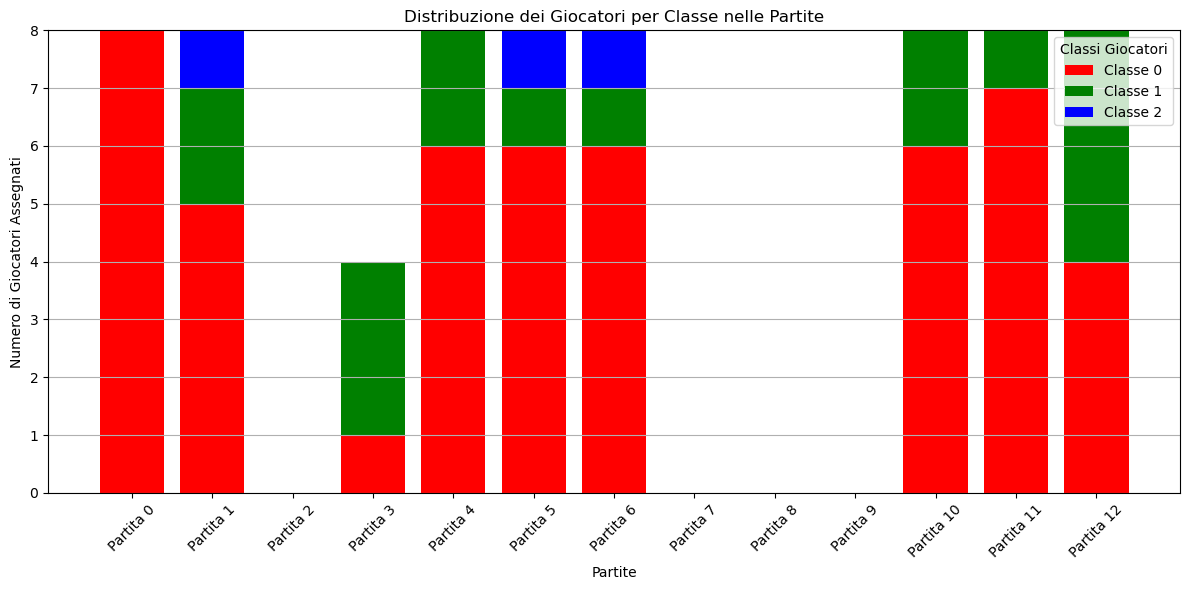

In [68]:
# Definizione delle costanti per le classi di ciascun giocatore
playerClassesConsts = [int(class_label) for class_label in dfSampleOfPlayers['cluster_label']]

# output della soluzione finale
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Soluzione trovata:')
    
    unassigned_players = []
    assigned_players = []
    assignments = [[] for _ in range(INSTANCES_AVAILABLE_MATCHES)]
    match_classes = []

    # Conta il numero di giocatori per classe in ciascuna partita
    players_per_class_per_match = [[0] * PLAYERS_CLASS_COUNT for _ in range(INSTANCES_AVAILABLE_MATCHES)]
    
    for p in range(AVAILABLE_PLAYERS):
        assigned = False
        for m in range(INSTANCES_AVAILABLE_MATCHES):
            if solver.Value(playersVars[p][m]) == 1:
                assigned_players.append(p)
                assignments[m].append(p)
                assigned = True
                # Assicurati che l'indice sia un intero
                players_per_class_per_match[m][int(playerClassesConsts[p])] += 1
                break
        if not assigned:
            unassigned_players.append(p)

    print(f'Giocatori non assegnati a nessuna partita: {len(unassigned_players)}')
    print(unassigned_players)

    # Colori per le classi
    class_colors = ['red', 'green', 'blue']

    # Creazione del grafico a barre impilate
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = [f'Partita {m}' for m in range(INSTANCES_AVAILABLE_MATCHES)]
    x = np.arange(len(labels))

    # Costruzione delle barre impilate
    bottom = np.zeros(len(labels))
    for c in range(PLAYERS_CLASS_COUNT):
        counts = [players_per_class_per_match[m][c] for m in range(INSTANCES_AVAILABLE_MATCHES)]
        ax.bar(x, counts, bottom=bottom, color=class_colors[c], label=f'Classe {c}')
        bottom += np.array(counts)

    # Aggiunta delle etichette e del titolo
    ax.set_xlabel('Partite')
    ax.set_ylabel('Numero di Giocatori Assegnati')
    ax.set_title('Distribuzione dei Giocatori per Classe nelle Partite')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(title='Classi Giocatori')
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()
else:
    print('Nessuna soluzione ottimale trovata')


### .5.3) Costruzione termini penalità funzione obiettivo_2 - istanza di sovraccarico


#### Tempo di attesa dei giocatori in coda
Minimizzare i giocatori non assegnati ad una partita che sono in attesa da più tempo. Questi verranno preferiti nelle assegnazioni alle partite, disincentivando l'abbandono del servizio da parte dell'utenza.


#### Partite con basso Rate quitting
Minimizzare nei giocatori assegnati ad una partita, i giocatori con un alto tasso di abbandono. Questo permetterà di favorire giocatori che mantengono le partite piene, inducendo quindi il pieno utilizzo delle risorse server(giocatori che abbandonano facilmente una partita, potrebbero richiedere di partecipare a nuove istanze, portando a non sfruttare pienamente le risorse). 


#### Proporzione delle partite istanziate
La proporzione delle partite istanziate per ospitare giocatori di una certa classe deve tendere alla proporzione delle classi dei giocatori in cerca di una partita. Si può ottenere minimizzando: 


#### Partite con giocatori della stessa classe
I giocatori appartenenti a una certa partita devono essere possibilmente della stessa classe(naturale), riducendo la possibilità che questi giocatori differiscano troppo tra loro.

In [128]:
### SOFT CONSTRAINT PROPORZIONE CLASSE DELLE PARTITE

lambda_penalty_4 = 1
#'''


scale_factor = 100
# Selezione campione casuale di 30 giocatori dal dataset dfClustered
# Supponendo che dfClustered sia già definito
# dfClustered = ...  # definisci o carica il dataframe dfClustered
selected_players = dfClustered.sample(n=AVAILABLE_PLAYERS, random_state=42)

# proporzione di giocatori di una certa classe rispetto al campione, scalata a valori interi

averagePlayers = []

for c in range(PLAYERS_CLASS_COUNT):
    class_players = selected_players[selected_players['cluster_label'] == c]
    proportion = (class_players.shape[0] / AVAILABLE_PLAYERS) * scale_factor
    averagePlayers.append(int(proportion))

# Definizione delle variabili per il numero di partite assegnate a ciascuna classe
matchesPerClass = [
    model.NewIntVar(0, INSTANCES_AVAILABLE_MATCHES, f'matches_for_class_{c}')
    for c in range(PLAYERS_CLASS_COUNT)
]

# collega alla variabile matchesPerClass[c] il numero di partite di una certa classe, sommando
# colonna(la colonna equivale alla classe)
for c in range(PLAYERS_CLASS_COUNT):
    model.Add(matchesPerClass[c] == sum(matches[m][c] for m in range(INSTANCES_AVAILABLE_MATCHES)))
    
'''
# rendi la somma della riga, pari a zero se la partita non è stata istanziata,
# ovvero non assegnare la partita ad alcuna classe
for m in range(INSTANCES_AVAILABLE_MATCHES):
    model.Add(sum(matches[m][c] for c in range(PLAYERS_CLASS_COUNT)) == 0).OnlyEnforceIf(matchesInstantiatedVars[m].Not())
'''

    
# Definisci variabili per la distanza tra la proporzione desiderata e quella effettiva
proportion_distance_terms = []
for c in range(PLAYERS_CLASS_COUNT):
    distance = model.NewIntVar(0, scale_factor * INSTANCES_AVAILABLE_MATCHES, f'distance_class_{c}')
    model.Add(distance >= matchesPerClass[c] * scale_factor - averagePlayers[c] * INSTANCES_AVAILABLE_MATCHES)
    model.Add(distance >= averagePlayers[c] * INSTANCES_AVAILABLE_MATCHES - matchesPerClass[c] * scale_factor)
    proportion_distance_terms.append(distance)
    

#'''

# Considerazioni finali
Le prestazioni della ricerca sono molto scarse, in quanto google or tool implementa una ricerca sistematica(con tutte le ottimizzazioni e le tecniche di pruning/ branch and bound), quindi visita tutto l'albero delle possibili soluzioni. Passare ad un solver che utilizzi un algoritmo di ricerca stocastica aiuterebbe la ricerca in termini di prestazioni, magari cercando la soluzione ottimale. Google or tool non implementa soluzioni di ricerca locale stocastica come simulated annealing. Avrei voluto approfondire il problema utilizzando implementazionio di ricerca locale stocastica per problemi vincolati. 

Giocatori non assegnati a nessuna partita:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202]
visualizza grafico


C:\Users\roman\AppData\Local\Temp\ipykernel_31504\185456224.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


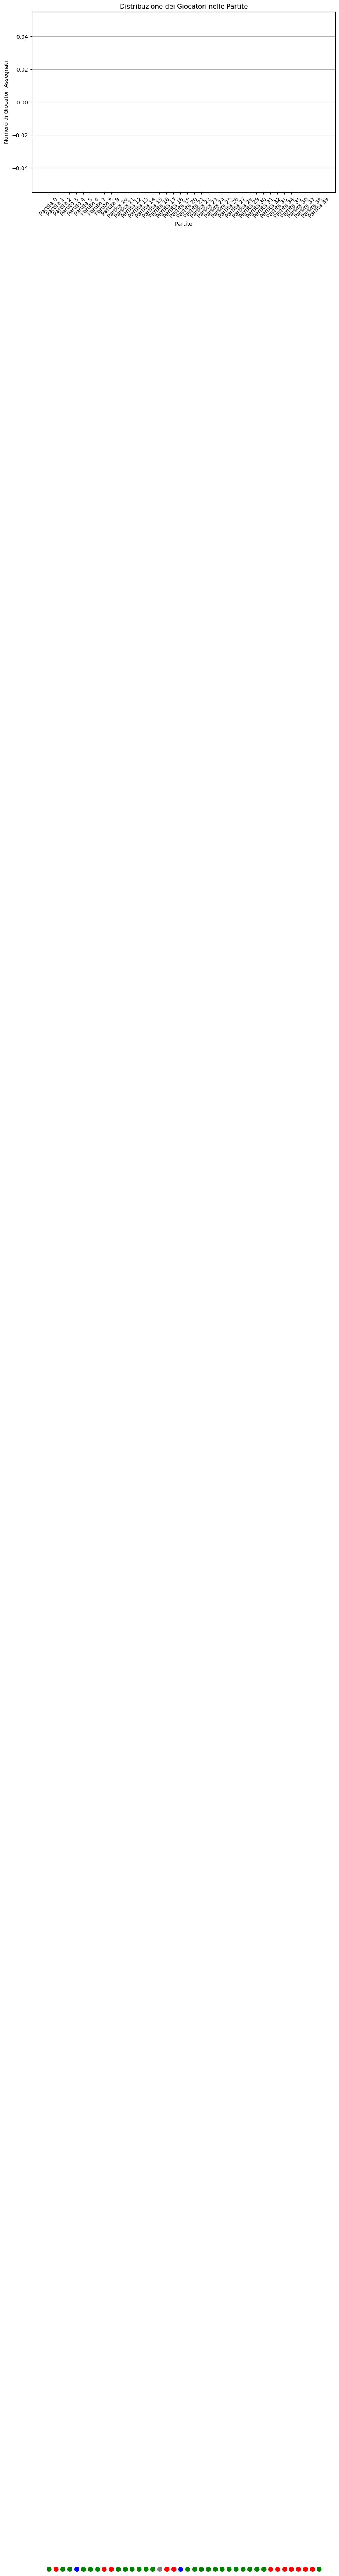

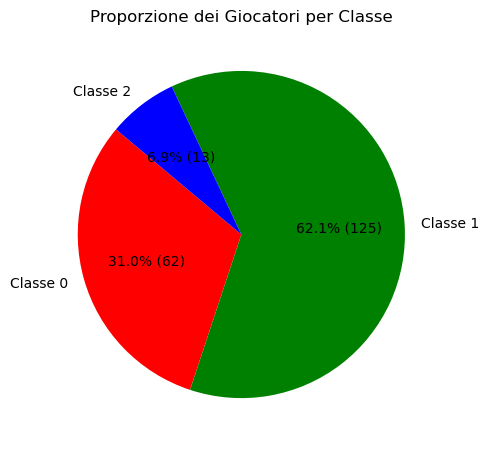

Soluzione trovata:
Partita 0: 0 giocatori assegnati, Classe 1
Partita 1: 0 giocatori assegnati, Classe 0
Partita 2: 0 giocatori assegnati, Classe 1
Partita 3: 0 giocatori assegnati, Classe 1
Partita 4: 0 giocatori assegnati, Classe 2
Partita 5: 0 giocatori assegnati, Classe 1
Partita 6: 0 giocatori assegnati, Classe 1
Partita 7: 0 giocatori assegnati, Classe 1
Partita 8: 0 giocatori assegnati, Classe 0
Partita 9: 0 giocatori assegnati, Classe 0
Partita 10: 0 giocatori assegnati, Classe 1
Partita 11: 0 giocatori assegnati, Classe 1
Partita 12: 0 giocatori assegnati, Classe 1
Partita 13: 0 giocatori assegnati, Classe 1
Partita 14: 0 giocatori assegnati, Classe 1
Partita 15: 0 giocatori assegnati, Classe 1
Partita 16: 0 giocatori assegnati, Classe -1
Partita 17: 0 giocatori assegnati, Classe 0
Partita 18: 0 giocatori assegnati, Classe 0
Partita 19: 0 giocatori assegnati, Classe 2
Partita 20: 0 giocatori assegnati, Classe 1
Partita 21: 0 giocatori assegnati, Classe 1
Partita 22: 0 giocator

In [129]:


# minimizzare la penalità totale
model.Minimize(
    lambda_penalty_4 * sum(proportion_distance_terms)
)

# solver e risoluzione
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120.0  # limite di tempo di 120 secondi
# risolvere il problema senza callback
status = solver.Solve(model)






# output della soluzione finale
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    unassigned_players = []
    assigned_players = []
    assignments = [[] for _ in range(INSTANCES_AVAILABLE_MATCHES)]
    match_classes = []

    for m in range(INSTANCES_AVAILABLE_MATCHES):
        for c in range(PLAYERS_CLASS_COUNT):
            if solver.Value(matchesVars[m][c]) == 1:
                match_classes.append(c)
                break
        else:
            match_classes.append(-1)  # Classe non assegnata

    for p in range(AVAILABLE_PLAYERS):
        assigned = False
        for m in range(INSTANCES_AVAILABLE_MATCHES):
            if solver.Value(playersVars[p][m]) == 1:
                assigned_players.append(p)
                assignments[m].append(p)
                assigned = True
                break
        if not assigned:
            unassigned_players.append(p)
    print(f'Giocatori non assegnati a nessuna partita:')
    print(unassigned_players)

    # visualizzazione grafica dei giocatori assegnati e non assegnati
    print('visualizza grafico')
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = []
    labels = []
    colors = []

    for m in range(INSTANCES_AVAILABLE_MATCHES):
        bars.append(solver.Value(playersInMatch[m]))
        labels.append(f'Partita {m}')
        if match_classes[m] == 0:
            colors.append('red')
        elif match_classes[m] == 1:
            colors.append('green')
        elif match_classes[m] == 2:
            colors.append('blue')
        else:
            colors.append('gray')

    x = np.arange(len(labels))
    ax.bar(x, bars, color='skyblue')  # Colore fisso per tutte le barre
    ax.set_xlabel('Partite')
    ax.set_ylabel('Numero di Giocatori Assegnati')
    ax.set_title('Distribuzione dei Giocatori nelle Partite')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(axis='y')

    # Aggiunta dei bollini colorati sotto al titolo della partita
    for i, (label, color) in enumerate(zip(labels, colors)):
        ax.text(x[i], -1.5, '●', color=color, fontsize=12, ha='center', va='top')

    # Aggiunta della legenda per i colori delle classi
    class_legend = {
        'Classe 0': 'red',
        'Classe 1': 'green',
        'Classe 2': 'blue',
        'Non Assegnata': 'gray'
    }
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in class_legend.values()]
    # ax.legend(handles, class_legend.keys(), title='Classi Giocatori')

    plt.tight_layout()
    plt.show()
    
    
    # proporzione partite di una certa classe
    # Visualizzazione delle proporzioni delle classi con un grafico a torta
    plt.figure(figsize=(5, 5))
    class_counts = [selected_players[selected_players['cluster_label'] == c].shape[0] for c in range(PLAYERS_CLASS_COUNT)]
    colors = ['red', 'green', 'blue']
    labels = [f'Classe {c}' for c in range(PLAYERS_CLASS_COUNT)]

    plt.pie(class_counts, labels=labels, colors=colors, autopct=lambda p: f'{p:.1f}% ({int(p * sum(class_counts) / 100)})', startangle=140)
    plt.title('Proporzione dei Giocatori per Classe')
    plt.tight_layout()
    plt.show()

    print('Soluzione trovata:')
    for m in range(INSTANCES_AVAILABLE_MATCHES):
        print(f'Partita {m}: {solver.Value(playersInMatch[m])} giocatori assegnati, Classe {match_classes[m]}')
else:
    print('Nessuna soluzione ottimale trovata')
